In [240]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import bebi103

import altair as alt
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

\begin{align}
I_\mathrm{norm}(t) \equiv I(t)/I_0 &= 
f_f\left(1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t)\right),\\[1mm]
\text{where } \psi_i(t) &= \frac{d_i}{2}\,\mathrm{erf}\left(\frac{d_i}{\sqrt{4Dt}}\right)
-\sqrt{\frac{D t}{\pi}}\left(1 - \mathrm{e}^{-d_i^2/4Dt}\right),
\end{align}

In [157]:
def fluo_bleach_psi(dx, D, t):
    return dx / 2 * scipy.special.erf(dx / np.sqrt(4 * D * t)) - \
           np.sqrt(D * t / np.pi) * (1 - np.exp(-np.power(dx,2) / (4 * D * t)))

def fluo_bleach_cal(t, f_b, f_f, k_off, D, dx=40*0.138, dy=40*0.138):
    if t < 0:
        return 1
    elif t == 0:
        return f_f * (1 - f_b)
    else:
        psi_x = fluo_bleach_psi(dx, D, t)
        psi_y = fluo_bleach_psi(dy, D, t)
        return f_f * (1 - f_b * (4 * np.exp(-1 * k_off * t)) / (dx * dy) * psi_x * psi_y)

In [22]:
fluo_bleach_cal(0,0.9,0.9,1,1)

0.08999999999999998

In [58]:
def data_prior_pred(t, n_ppc_samples=1):
    '''
    Samples parameter values according to the prior and generates
    data y at the values given in x.
    '''
    sigma = np.abs(np.random.normal(0, 0, size=n_ppc_samples))
    i_0 = np.random.normal(1, sigma, size=n_ppc_samples)
    k_off = np.random.lognormal(np.log(1), 0.5, size=n_ppc_samples)
    D = np.random.lognormal(np.log(1), 0.75, size=n_ppc_samples)
    fb = np.random.beta(6, 3, size=n_ppc_samples)
    ff = np.random.beta(15, 2, size=n_ppc_samples)
    data = np.array([np.random.normal(fluo_bleach_cal(t0, fb, ff, k_off, D),
                                      sigma, size=1) 
                        for t0 in t])
    return np.concatenate(data)

In [24]:
df = pd.read_csv('hw_4.1_frap_image_processing_results.csv')
df.head()

,mean_intensity,time,trial,normalized_intensity
0,786.469375,-3.760,0,1.014676
1,766.556875,-3.572,0,0.988986
2,777.139375,-3.384,0,1.002639
3,787.697500,-3.196,0,1.016261
4,769.598750,-3.008,0,0.992910


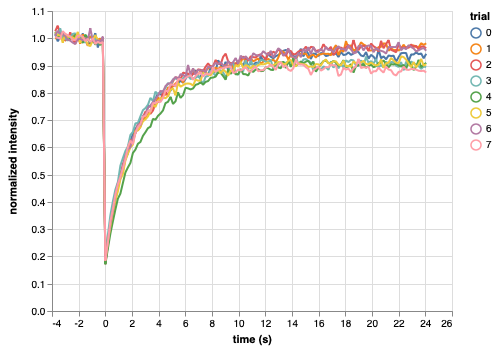

In [23]:
alt.Chart(df
    ).mark_line(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('time:Q', title='time (s)'),
        y=alt.Y('normalized_intensity:Q', title='normalized intensity'),
        color='trial:N',
        order='time:Q'
    )

In [95]:
t = df.loc[df['trial']==1, 'time'].values
v1 = df.loc[df['trial']==1, 'normalized_intensity'].values

In [227]:
def data_prior_pred(t, n_ppc_samples=1):
    '''
    Samples parameter values according to the prior and generates
    data y at the values given in x.
    '''
#     sigma = np.abs(np.random.normal(0, 0.01, size=n_ppc_samples))
#     i_0 = np.random.normal(1, sigma, size=n_ppc_samples)
#     k_off = np.random.lognormal(np.log(0.2), 0.5, size=n_ppc_samples)
#     D = np.random.lognormal(np.log(0.3), 0.75, size=n_ppc_samples)
#     fb = np.random.beta(6, 3, size=n_ppc_samples)
#     ff = np.random.beta(15, 1, size=n_ppc_samples)
    fb, ff, k_off, D, sigma = [0.86130123, 0.96535866, 0.13684066, 0.80284614, 0.0130514]
    data = np.array([np.random.normal(fluo_bleach_cal(t0, fb, ff, k_off, D),
                                      sigma, size=1) 
                        for t0 in t])
    return np.concatenate(data)

In [228]:
colors = bokeh.palettes.all_palettes['Category20'][20]

p = bokeh.plotting.figure(height=300, width=450,
                          x_axis_label='BMI',
                          y_axis_label='Score (scaled)')

# Plot simulated data
for i in range(20):
    p.line(t, data_prior_pred(t), color=colors[i],
             alpha=0.8)

# Plot original data
p.circle(t, v1, color='black', size=4)
bokeh.io.show(p)

In [150]:
def log_prior(params):
    
    fb, ff, k_off, D, sigma = params

    log_prior = st.beta.logpdf(fb, 6, 3, loc=0)
    log_prior += st.beta.logpdf(ff, 15, 1, loc=0)
    log_prior += st.lognorm.logpdf(k_off, 0.5, loc=0, scale=0.2)
    log_prior += st.lognorm.logpdf(D, 0.75, loc=0, scale=0.3)
    log_prior += st.halfnorm.logpdf(sigma, 0, 0.01)
    
    return log_prior

def log_like(params, t, y):
    fb, ff, k_off, D, sigma = params
    
    log_like = np.sum([st.norm.logpdf(y0, fluo_bleach_cal(t0, fb, ff, k_off, D), sigma)
                       for y0,t0 in zip(y,t)])
    
    return log_like

In [151]:
def log_post(params, t, y):
    return log_prior(params) + log_like(params, t, y)

def neg_log_post(params, t, y):
    return -log_post(params, t, y)

In [236]:
# Specify arguments
args = (t, v1)

# Choose initial condition
params_0 = [0.9, 0.9, 0.2, 0.3, 0.01]

# Compute the MAP values
opt_res = scipy.optimize.minimize(neg_log_post, params_0, args=args,
                                  method='SLSQP')

/Users/zhiyangjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/zhiyangjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [247]:
popt = opt_res.x
print(popt)

[0.86129599 0.96535866 0.13684461 0.80281412 0.01305148]


In [245]:
hes = smnd.approx_hess(popt, log_post, args=args)

In [246]:
# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Look at it
for i in range(5):
    print(cov[i][i])
    

0.00013180256552117872
1.0287153461551824e-05
0.00026028103018816085
0.009730754276567206
5.602905928934168e-07


In [188]:
fb, ff, k_off, D, sigma = params_0
np.sum([st.norm.logpdf(y0, fluo_bleach_cal(t0, fb, ff, k_off, D), sigma)
                       for t0,y0 in zip(t,v1)])
sigma

0.1

In [139]:
fb = np.linspace(0,1,2000)
log_prior = st.beta.logpdf(fb, 3, 3, loc=0)

In [134]:
# Set up plotting range
phi = np.linspace(32, 33.5, 200)
phi_ = st.lognorm.logpdf(30, 0.75, loc=0, scale=20)

In [140]:
p = bokeh.plotting.figure(height=300, width=450,
                          x_axis_label='BMI',
                          y_axis_label='Score (scaled)')

p.circle(fb, np.exp(log_prior), color='black', size=4)
bokeh.io.show(p)

In [131]:
st.beta.logpdf?

Signature: st.beta.logpdf(x, *args, **kwds)
Docstring:
Log of the probability density function at x of the given RV.

This uses a more numerically accurate calculation if available.

Parameters
----------
x : array_like
    quantiles
arg1, arg2, arg3,... : array_like
    The shape parameter(s) for the distribution (see docstring of the
    instance object for more information)
loc : array_like, optional
    location parameter (default=0)
scale : array_like, optional
    scale parameter (default=1)

Returns
-------
logpdf : array_like
    Log of the probability density function evaluated at x
File:      /Users/zhiyangjin/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [135]:
phi_

-4.178588912542305